In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : AARstsQ1 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

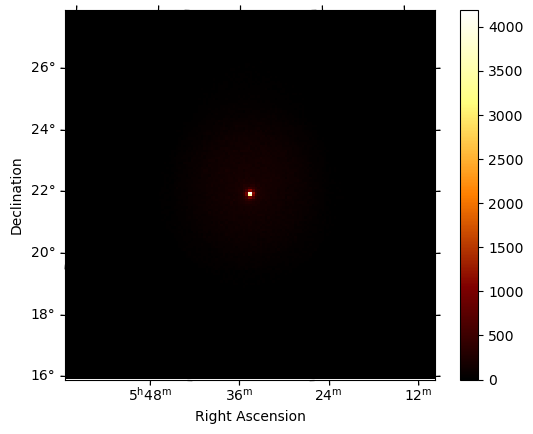

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
true_energy = dataset_standard.exposure.geom.axes[0].center.value


eshift_neg = -0.1
eshift_pos = +0.1
eshift_cor = 0.0



In [5]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [6]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        eshift = eshift_cor, 
                        rnd = False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        eshift = eshift_neg, 
                        rnd = False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        eshift = eshift_pos, 
                        rnd = False)
dataset_pos = sys_d_pos.create_dataset()



In [7]:
def set_model_N(energy_nuisance):
    models = Models.read(f"{path_crab}/standard_model.yml").copy()
    model_spectrum  = PowerLawNuisanceESpectralModel(
        index=2.3,
        index_nuisance = 0,
        amplitude="1e-12 TeV-1 cm-2 s-1",  
        energy_nuisance = energy_nuisance)

    source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                           spectral_model = model_spectrum,
                           name = "SourceN")  
    source_model.parameters['lon_0'].frozen = True
    source_model.parameters['lat_0'].frozen = True
    models = Models(source_model)
    return models

In [8]:
def powerlaw(E, amplitude, index, nuisance):
    return amplitude * (E* (1+ nuisance)/1) ** (-index)

[]

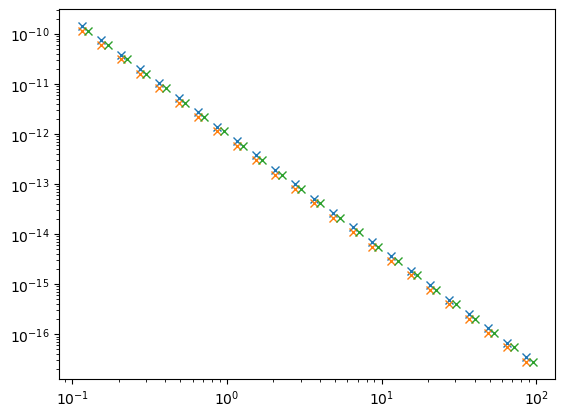

In [9]:

testt =powerlaw(true_energy, 1e-12, 2.3, 0 )
testt2 = powerlaw(true_energy, 1e-12, 2.3, 0.1 )

plt.plot( true_energy, testt, 'x')
plt.plot( true_energy, testt2, 'x')
plt.plot( true_energy * 1.1, testt2, 'x')

plt.loglog()

/tmp/ipykernel_3998075/4088057659.py:22: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(true_energy, npred / npred, label = "Model ")
/tmp/ipykernel_3998075/4088057659.py:23: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(true_energy, npred_neg / npred,
/tmp/ipykernel_3998075/4088057659.py:25: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(true_energy, npred_pos / npred,


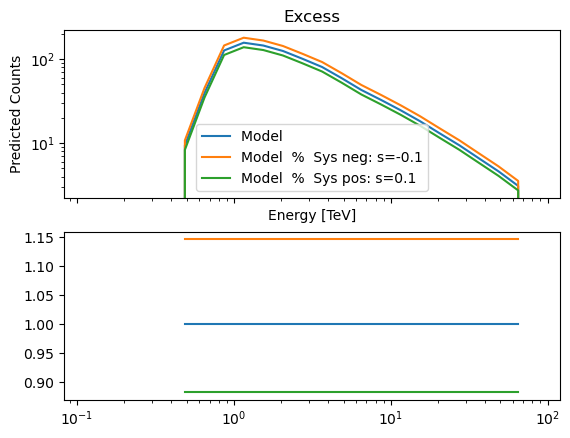

In [10]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV


fig,(ax,ax1) = plt.subplots(2,1,sharex = True)
npred = (dataset_cor.counts -dataset_cor.background).data.sum(axis = 2).sum(axis= 1)
npred_neg = (dataset_neg.counts -dataset_neg.background).data.sum(axis = 2).sum(axis= 1)
npred_pos = (dataset_pos.counts -dataset_pos.background).data.sum(axis = 2).sum(axis= 1)


ax.plot(true_energy, npred, label = "Model ")
ax.plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={eshift_neg:.1}")
ax.plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={eshift_pos:.1}")

         
ax.loglog()
ax.legend()
ax.set_xlabel("Energy [TeV]")
ax.set_ylabel("Predicted Counts")

ax1.plot(true_energy, npred / npred, label = "Model ")
ax1.plot(true_energy, npred_neg / npred, 
         label =f"Model  %  Sys neg: s={eshift_neg:.1}")
ax1.plot(true_energy, npred_pos / npred,  
         label =f"Model  %  Sys pos: s={eshift_pos:.1}")

ax.set_title("Excess")
fig = plt.gcf()
fig.savefig("plots/1_excess.pdf")



In [11]:
print(dataset_cor.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : V3LOvN5K-bkg
  Datasets names            : ['V3LOvN5K']
  Spectral model type       : PowerLawNormSpectralModel
  Parameter

In [12]:
print(dataset_neg.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : E-bLmssv-bkg
  Datasets names            : ['E-bLmssv']
  Spectral model type       : PowerLawNormSpectralModel
  Parameter

/tmp/ipykernel_3998075/1774729548.py:22: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(true_energy, npred / npred, label = "Model ")
/tmp/ipykernel_3998075/1774729548.py:23: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(true_energy, npred_neg / npred,
/tmp/ipykernel_3998075/1774729548.py:25: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(true_energy, npred_pos / npred,


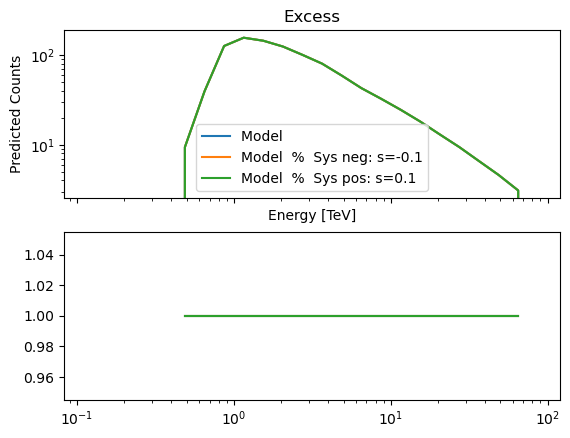

In [13]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV


fig,(ax,ax1) = plt.subplots(2,1,sharex = True)
npred = (dataset_cor.npred_signal()).data.sum(axis = 2).sum(axis= 1)
npred_neg = (dataset_neg.npred_signal()).data.sum(axis = 2).sum(axis= 1)
npred_pos = (dataset_pos.npred_signal()).data.sum(axis = 2).sum(axis= 1)


ax.plot(true_energy, npred, label = "Model ")
ax.plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={eshift_neg:.1}")
ax.plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={eshift_pos:.1}")

         
ax.loglog()
ax.legend()
ax.set_xlabel("Energy [TeV]")
ax.set_ylabel("Predicted Counts")

ax1.plot(true_energy, npred / npred, label = "Model ")
ax1.plot(true_energy, npred_neg / npred, 
         label =f"Model  %  Sys neg: s={eshift_neg:.1}")
ax1.plot(true_energy, npred_pos / npred,  
         label =f"Model  %  Sys pos: s={eshift_pos:.1}")

ax.set_title("Npred")
fig = plt.gcf()
fig.savefig("plots/1_excess.pdf")



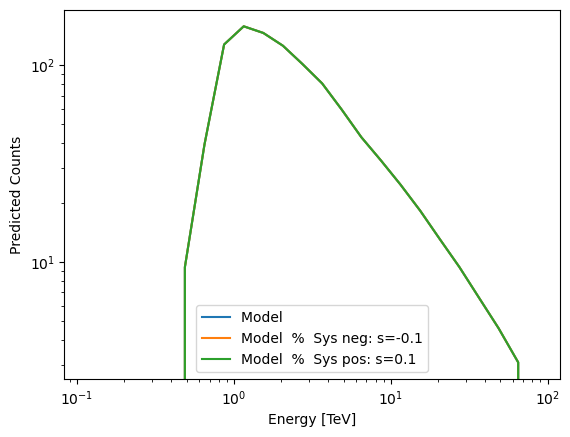

In [14]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred = dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


plt.plot(true_energy, npred, label = "Model ")
plt.plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={eshift_neg:.1}")
plt.plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={eshift_pos:.1}")

         
plt.loglog()
plt.legend()
plt.xlabel("Energy [TeV]")
plt.ylabel("Predicted Counts")

fig = plt.gcf()
fig.savefig("plots/1_counts.pdf")

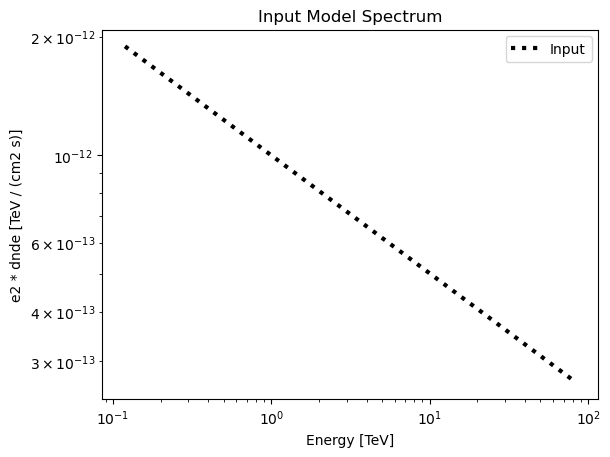

In [15]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_standard.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

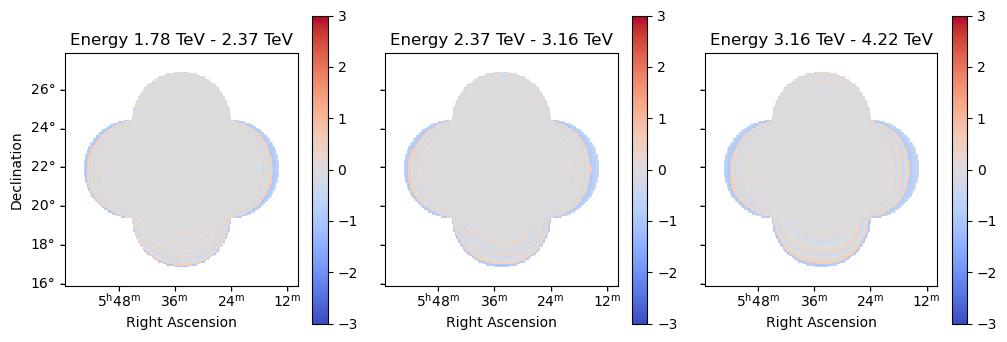

In [16]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
vmax = 3
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

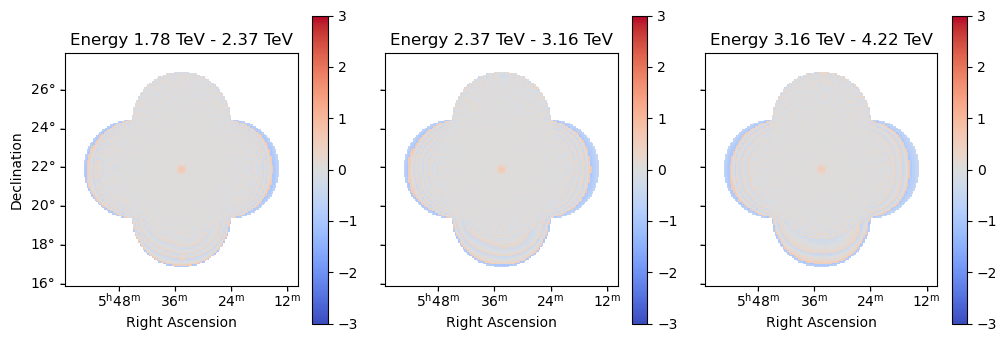

In [17]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

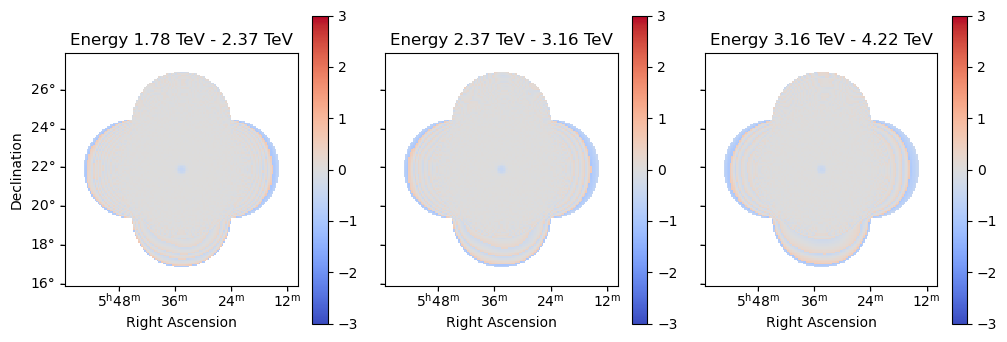

In [18]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

In [19]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])

CPU times: user 8.38 s, sys: 92.9 ms, total: 8.47 s
Wall time: 8.46 s


In [21]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("best fit amplitude")
amplitudes = []
m = dataset_standard.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices = []
m = dataset_standard.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_standard.background_model.parameters['norm'].value 
error = dataset_standard.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
    
    
    
with open('data/1_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
    
dataset_neg.models.write("data/1_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1_model_cor.yml", overwrite= True)

best fit amplitude
====
Input
1e-12 pm 0
====
1.1476636130325543e-12 pm 9.221252687849379e-14
1e-12 pm 8.982377778353663e-14
8.847764897222826e-13 pm 8.910437099964209e-14

best fit Index
====
Input
2.3 pm 0
====
2.300486246782885 pm 0.05583440339251278
2.3 pm 0.061716371768353546
2.3011635346501405 pm 0.06927985255547313

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.000002931685497 pm 0.0020661732877990655
1.0 pm 0.00206238916408096
0.9999554856548009 pm 0.0020195944957923594


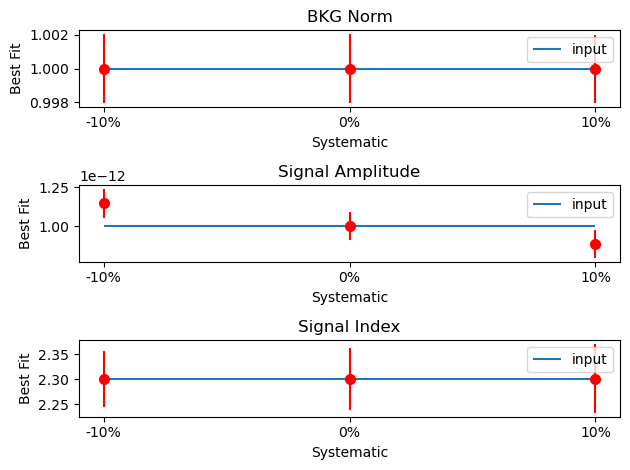

In [24]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_standard.pdf")   


index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude


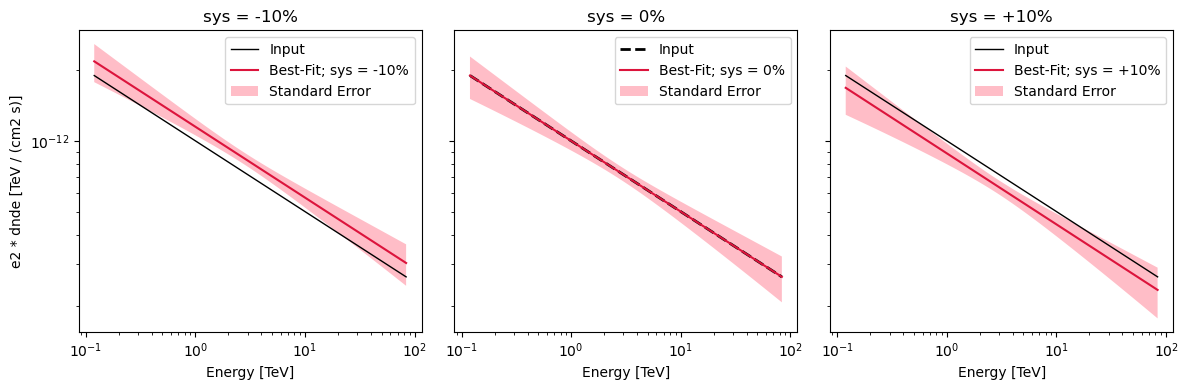

In [25]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

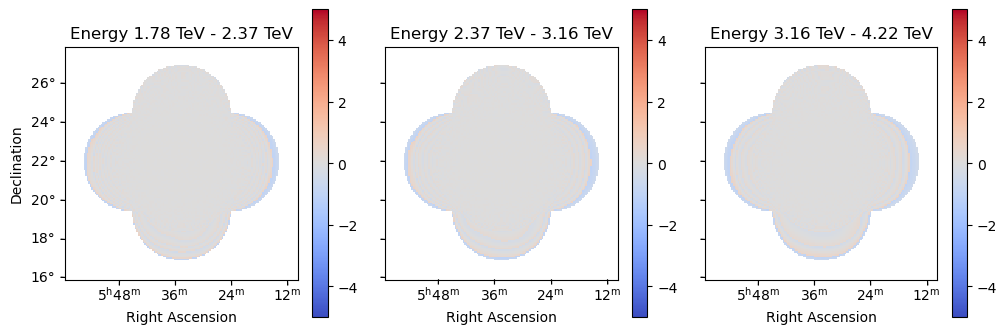

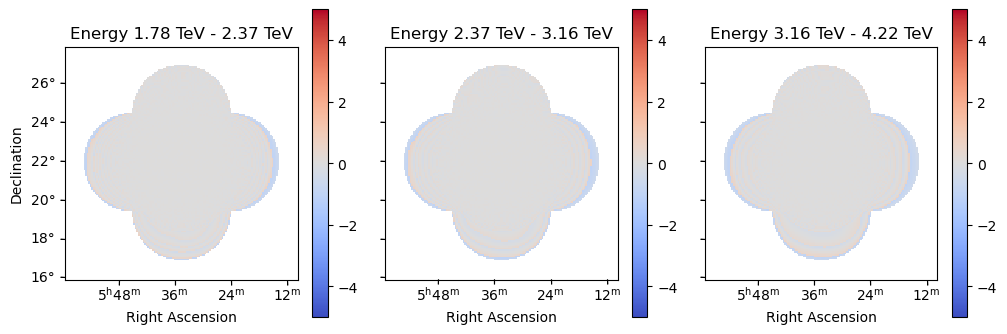

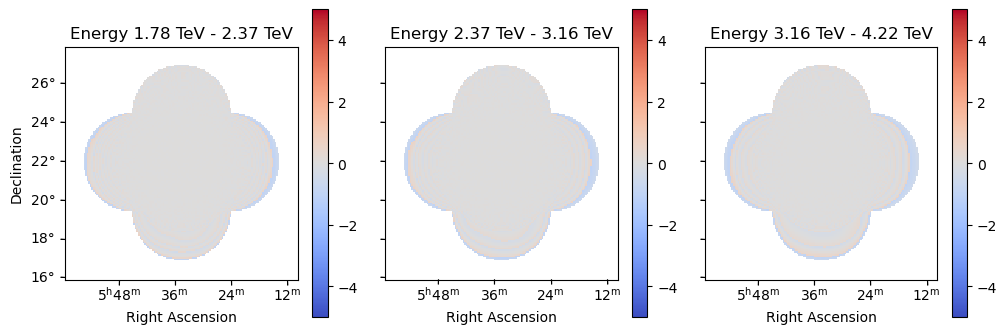

In [26]:

estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);